# Making maps

I'm using a small dataset originally from [**Geoff Bohling**](http://people.ku.edu/~gbohling/) at the Kansas Geological Survey. I can no longer find the data online, but here's what he says about it:

> Our example data consist of vertically averaged porosity values, in percent, in Zone A of the Big Bean Oil Field (fictitious, but based on real data). Porosity values are available from 85 wells distributed throughout the field, which is approximately 20 km in east-west extent and 16 km north-south. The porosities range from 12% to 17%.

[Read more about it](http://discoverspatial.in/wp-content/uploads/2018/04/IntroToGeostatistics-Geoff-Bohling.pdf)

We will look at four ways to do this:

- Using SciPy with `scipy.interpolate.RBFInterpolator` (**requires SciPy 1.7.0+**)
- Using SciPy with `scipy.griddata()`
- Using the Scikit-Learn machine learning library with `sklearn.gaussian_process`
- Using the [Verde](https://github.com/fatiando/verde) spatial gridding library with `verde.Spline` (thank you to Leo Uieda for contributing this!)

### TODO

- Export to TXT and GeoTIFF


## Load and inspect the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### EXERCISE

The data file is on the web at `https://www.dropbox.com/s/6dyfc4fl5slhgry/ZoneA.dat?raw=1` and `https://geocomp.s3.amazonaws.com/data/ZoneA.dat`.

Load the data from the text file into a Pandas DataFrame. <a title="Use Pandas's read_csv() method. You will need to set some arguments: sep, header, usecols, names, and dtype."><b>Hover for HINT</b></a>

We don't need all of the fields, but we at least need x, y, thickness and porosity. The top of the DataFrame should look something like this:

              x       y     thick       por
    0   12100.0  8300.0   37.1531   14.6515
    1    5300.0  8700.0   31.4993   14.5093
    
Once you have the data, can you make a KDE plot (`sns.kdeplot()`) with Seaborn?

In [2]:
# YOUR CODE HERE
fname = "https://geocomp.s3.amazonaws.com/data/ZoneA.dat"



In [3]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/ZoneA.dat',
                 sep=' ',
                 header=9,
                 usecols=[0, 1, 2, 3, 4],
                 names=['x', 'y', 'thick', 'por', 'perm'],
                 dtype="float64",
                 na_values=[-999.9999],
                )

df.head()

,x,y,thick,por,perm
0,12100.0,8300.0,37.1531,14.6515,2.8547
1,5300.0,8700.0,31.4993,14.5093,NaN
2,3500.0,13900.0,36.9185,14.0639,NaN
3,5100.0,1900.0,24.0156,15.1084,1.1407
4,9900.0,13700.0,35.0411,13.9190,NaN


This looks a bit unpleasant, but we're just getting out min and max values for the x and y columns.

In [4]:
extent = x_min, x_max, y_min, y_max = [df.x.min()-1000, df.x.max()+1000,
                                       df.y.min()-1000, df.y.max()+1000]

Later on, we'll see a nicer way to do this using the Verde library.

Now we can plot the data:

### EXERCISE

Make a map of the porosity data. Use the colour of the points to indicate porosity, and use the size to indicate thickness of the zone.

Add a colourbar, title, and other annotation.

In [5]:
# YOUR CODE HERE



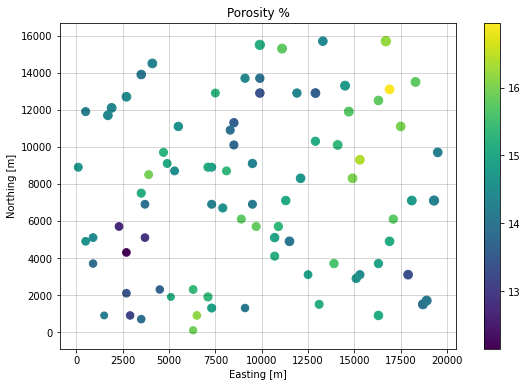

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

scatter = ax.scatter(df.x, df.y, c=df.por, s=2*df.thick)
plt.colorbar(scatter)
ax.set_aspect(1)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Porosity %')
ax.grid(c='k', alpha=0.2)

plt.show()

## Make a regular grid

We must make a grid, which represents the points we'd like to predict.

In [51]:
# Notice the order of x (columns) and y (rows)!
grid = np.mgrid[y_min:y_max:500, x_min:x_max:500]
grid.shape

# Use *shape* argument to specify the *number* (not size) of bins:
# grid_y, grid_x = np.mgrid[y_min:y_max:100j, x_min:x_max:100j]

(2, 36, 43)

In [52]:
_, *shape = grid.shape
grid_ = grid.reshape(2, -1)

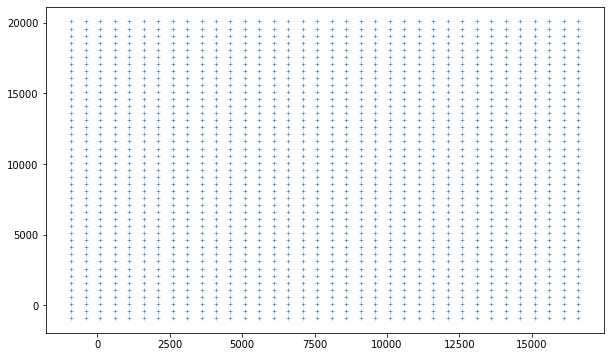

In [53]:
plt.figure(figsize=(10,6))
plt.scatter(*grid, marker='+', lw=0.5, s=10)

That was easy!

----

## Interpolation with radial basis function

Now we make an interpolator and use it to predict into the grid 'cells'.

**This requires SciPy 1.7.0+ (June 2021), otherwise you'll have to use `scipy.interpolate.Rbf`.**

In [9]:
from scipy.interpolate import RBFInterpolator

rbfi = 

SyntaxError: invalid syntax (<ipython-input-9-79dd330f8521>, line 3)

In [76]:
from scipy.interpolate import RBFInterpolator

# Make an n-dimensional interpolator. This is essential line number 4.
rbfi = RBFInterpolator(df[['x', 'y']], df.por, epsilon=1)

# Predict on the regular grid. Line 5.
di = rbfi(grid_.T).reshape(shape)

In [77]:
di.shape

(36, 43)

Let's plot the result. First, we'll need the min and max of the combined sparse and gridded data, so we can plot them with the same colourmap ranges:

In [57]:
mi = np.min(np.hstack([di.ravel(), df.por]))
ma = np.max(np.hstack([di.ravel(), df.por]))

### EXERCISE

Can you make a plot of the interpolated surface, with the original data overplotted in the same colours?

You'll need to use `mi` and `ma` to control the colourbars. And you will need the transpose (`arr.T`)  and `imshow()`'s `origin='lower'` argument to keep everything matched up with the original dataset.

In [58]:
# YOUR CODE HERE



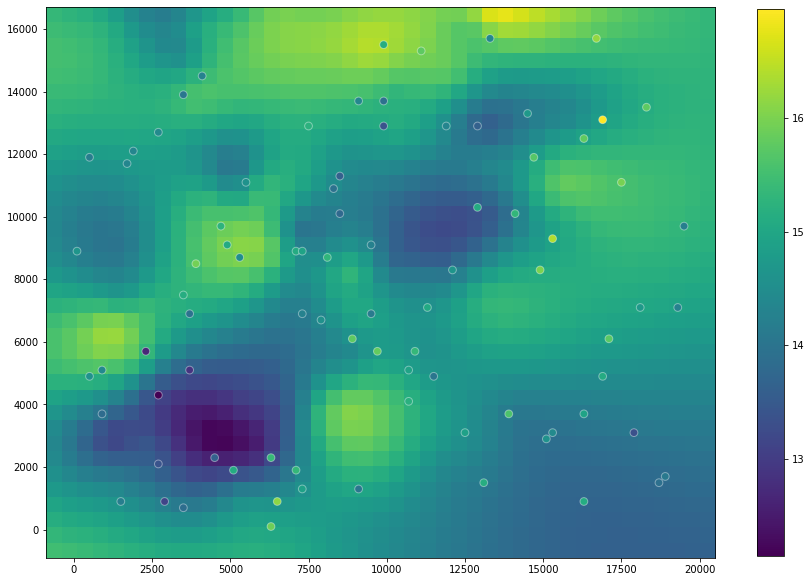

In [72]:
plt.figure(figsize=(15,15))
c1 = plt.imshow(di, origin="lower", extent=extent, vmin=mi, vmax=ma, aspect=1)
c2 = plt.scatter(df.x, df.y, s=60, c=df.por, edgecolor='#ffffff66', vmin=mi, vmax=ma)

plt.colorbar(c1, shrink=0.67)
plt.show()

The circles (the data) are the same colour as the grid (the model), so we can see that the error on this prediction is almost zero. In fact, the default parameters force the model to pass through all the data points (interpolation, as opposed to estimation or approximation).

### EXERCISE

Make a histogram and kernel density estimation of the residuals. <a title="Make predictions at the original input locations then subtract the original porosity data from those. Use sns.distplot() to plot them."><b>Hover for HINT</b></a>

Repeat the exercise but change the smoothing parameter (e.g. to 0.2) to see the effect on the residuals.

In [ ]:
# YOUR CODE HERE



In [73]:
import seaborn as sns

por_hat = rbfi(df.x, df.y)

sns.distplot(por_hat - df.por)

TypeError: __call__() takes 2 positional arguments but 3 were given

The `Rbf()` interpolator has [a few options](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html). The most important one is probably `smooth`, which is the thing to increase if you end up with a singular matrix (because it can't converge on a solution). Anything above 0 relaxes the constraint that the surface must pass through every point. If you get an error, you probably need to change the smoothing.

You can also change the `function` (default is `multiquadric`, which also has an `epsilon` parameter to vary the range of influence of each point).

In [74]:
rbfi = Rbf(df.x, df.y, df.por, smooth=0.2)
di = rbfi(grid_x, grid_y)

plt.imshow(di, origin="lower", extent=extent)
plt.scatter(df.x, df.y, s=2, c='w')
plt.show()

NameError: name 'Rbf' is not defined

### EXERCISE

Make an interactive plot to see the effect of the smoothing parameter on `Rbf`.

In [ ]:
# YOUR CODE HERE



In [ ]:
from ipywidgets import interact

@interact(smooth=(0, 1, 0.1), epsilon=(100, 5_000, 200))
def main(smooth, epsilon):
    rbfi = Rbf(df.x, df.y, df.por, smooth=smooth, epsilon=epsilon)

    di = rbfi(grid_x, grid_y)
    por_hat = rbfi(df.x, df.y)

    residuals = por_hat - df.por

    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

    mi = np.min(np.hstack([di.ravel(), df.por.values]))
    ma = np.max(np.hstack([di.ravel(), df.por.values]))

    im = axs[0].imshow(di, origin='lower', extent=extent, vmin=mi, vmax=ma)
    sns.scatterplot(df.x, df.y, hue=df.por, palette='viridis', vmin=mi, vmax=ma, ax=axs[0])

    sns.distplot(residuals, ax=axs[1])
    axs[1].set_xlim(-2, 2)
    
    plt.show()
    return

### EXERCISE

Use `plt.contour()` or `plt.contourf()` to make a contour map of this surface.

In [ ]:
# YOUR CODE HERE



In [ ]:
plt.figure(figsize=(15, 10))

plt.contourf(di, origin="lower", extent=extent,
             levels=np.arange(12, 18, 0.2),
            )
plt.contour(di, origin="lower", extent=extent,
            levels=np.arange(12, 18, 0.2),
            linewidths=[1], colors=['k'], alpha=0.2
           )
plt.scatter(df.x, df.y, s=12, c='w')

plt.show()

## Interpolation with `scipy.griddata()`

The `Rbf()` interpolator is the one to know about, because it has lots of useful parameters. It's probably the only one you need to know. But there is also `scipy.griddata()`. For example see [this SciPy recipe](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.griddata.html).

The interface is slightly different &mdash; we have to pass a single array of the coordinates (the (x, y) locations of the points we know). We also pass the values to interpolate, and the grids.

The function will not accept Pandas `Series` objects, so we'll use the `Series.values` attribute to get at the NumPy array representation.

First, let's make the 2D array of coordinates:

In [78]:
points = df[['x', 'y']].values

The gridding step is easy. We'll try three different algorithms:

In [82]:
from scipy.interpolate import griddata

grid_z0 = griddata(points, df.por.values, grid.T, method='nearest')
grid_z1 = griddata(points, df.por.values, grid.T, method='linear')
grid_z2 = griddata(points, df.por.values, grid.T, method='cubic')

Inspect the results.

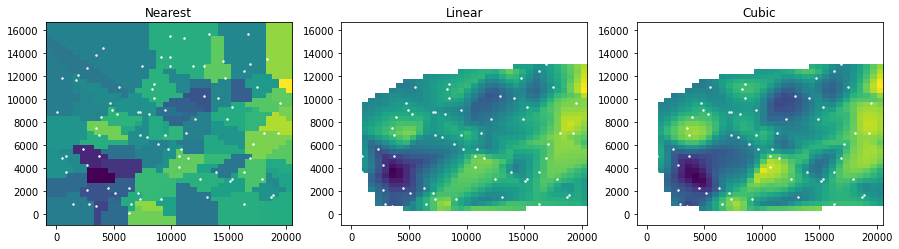

In [83]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(grid_z0, origin='lower', extent=extent)
ax.scatter(df.x, df.y, s=2, c='w')
ax.set_title('Nearest')

ax = axs[1]
ax.imshow(grid_z1, origin='lower', extent=extent)
ax.scatter(df.x, df.y, s=2, c='w')
ax.set_title('Linear')

ax = axs[2]
ax.imshow(grid_z2, origin='lower', extent=extent)
ax.scatter(df.x, df.y, s=2, c='w')
ax.set_title('Cubic')

plt.show()

I don't particularly like any of these results.

## Using `sklearn.gaussian_process`

Modeling with a Gaussian process is equivalent to kriging. Conveniently, the popular machine learning library `scikit-learn` has a Gaussian process modeling tool.

In [ ]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1000)

The main hyperparameters are the kernel, which we just defined, and `alpha`, which controls the smoothness. Larger values imply mmore noise in the input data, and result in smoother grids; default is very small: 1 &times; 10<sup>-9</sup>.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(normalize_y=True,
                              alpha=0.1,  # Larger values imply more noise in the input data.
                              kernel=kernel,)

gp.fit(df[['x', 'y']].values, df.por.values)

To make a prediction, we need to construct the X matrix: (x, y) coordinates in 2 columns:

In [ ]:
X_grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T

Now we can make a prediction:

In [ ]:
y_grid = gp.predict(X_grid).reshape(grid_x.shape)

And plot the predicted grid with the input data using the same colourmap:

In [ ]:
# Compute min and max of all the data:
mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(y_grid, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

As before, we can compute the error by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

In [ ]:
por_hat = gp.predict(df[['x', 'y']].values)

sns.distplot(por_hat - df.por)

In [ ]:
df['por_Rbf'] = rbfi(df.x, df.y)
df['por_GP'] = gp.predict(df[['x', 'y']].values)

sns.distplot(df['por_Rbf'] - df.por)
sns.distplot(df['por_GP'] - df.por)

### EXERCISE

Try some other regressors in `scikit-learn`. Look at the maps they produce, and check their residuals. (You might want to write a loop to check several models.)

Which regressors produce the best maps? 

In [ ]:
# YOUR CODE HERE



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

models =  {
    'Gauss': GaussianProcessRegressor(normalize_y=True, alpha=0.1, kernel=kernel),
    'LinReg': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5, weights='distance'),
    'RForest': RandomForestRegressor(),
    'SVM': SVR(),
    'NNet': MLPRegressor(hidden_layer_sizes=[100, 100, 100,]),
}

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

for (model, regr), ax in zip(models.items(), axs.ravel()):
    regr.fit(df[['x', 'y']].values, df.por.values)
    y_grid = regr.predict(X_grid).reshape(grid_x.shape)
    
    mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
    ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

    im = ax.imshow(y_grid, origin='lower', extent=extent, vmin=mi, vmax=ma)
    pts = ax.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
    ax.set_title(model)

plt.show()

----

## Using `verde.Spline`

One of the options in scipy's `Rbf` interpolator is the "thin-plate" kernel. This is what the `verde.Spline` interpolator is based on but with a few modifications, like damping regularization to smooth the solution. It's similar to the `RBF` and `GaussianProcessRegressor` approach but Verde provides a more convenient API for gridding tasks.

For example, we now have a nicer way to define `extent`, using `vd.pad_region()`:

In [ ]:
import verde as vd

extent = x_min, x_max, y_min, y_max = vd.pad_region(vd.get_region((df.x, df.y)), pad=1000)

In [ ]:
spline = vd.Spline(mindist=2000, damping=1e-4)

spline.fit((df.x, df.y), df.por)

To make a grid, use the `.grid` method of the spline:

In [ ]:
grid = spline.grid(region=extent, spacing=500)
grid

This returns an [`xarray.Dataset`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html#xarray.Dataset) which can be easily plotted, saved to disk as netCDF, or used for computations. The coordinates for the grid are automatically generated and populated based on the desired region and spacing. The spacing is adjusted to fit the desired region exactly. Optionally, you can set `adjust="region"` to adjust the size of the region so that the spacing is exact.

And plot the predicted grid with the input data using the same colourmap:

In [ ]:
# Compute min and max of all the data:
mi = np.min(np.hstack([grid.scalars.values.ravel(), df.por.values]))
ma = np.max(np.hstack([grid.scalars.values.ravel(), df.por.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(grid.scalars, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

As before, we can compute the error by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

In [ ]:
por_hat = spline.predict((df.x, df.y))

sns.distplot(por_hat - df.por)

Having an `xarray` is very convenient because these objects are easy to save out in HDF5 or netCDF format, and will play nicely with `segysak` (for example). 

They also make it easier to do things like get profiles out of the map. Indeed, Verde makes this easier still:

In [ ]:
prof = spline.profile(point1=(0, 0), point2=(20_000, 16_000), size=200)
prof.head()

In [ ]:
plt.plot(prof.distance, prof.scalars)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(15,6))

ax = axs[0]
ax.imshow(grid.scalars, origin='lower', extent=extent, vmin=mi, vmax=ma)
ax.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
ax.plot([0, 20_000], [0, 16_000], c='r', lw=3)

ax = axs[1]
ax.plot(prof.distance, prof.scalars, "r-", lw=2)

plt.show()

## Another `verde` example

This uses another dataset that Verde can download: [the Baja California bathymetry data](https://www.fatiando.org/verde/v1.0.0/sample_data/baja_bathymetry.html#sphx-glr-sample-data-baja-bathymetry-py).

In [ ]:
import verde as vd

data = vd.datasets.fetch_baja_bathymetry()

data.head()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(9, 8))

ax = plt.axes(projection=ccrs.Mercator())

# Cartopy requires setting the projection of the original data through
# the transform argument. Use PlateCarree for geographic data.
plt.scatter(
    data.longitude,
    data.latitude,
    c=data.bathymetry_m,
    s=0.1,
    transform=ccrs.PlateCarree(),
)
plt.colorbar().set_label("meters")
ax.set_title("Bathymetry from Baja California")

# Use an utility function to add tick labels and land and ocean features to the map.
vd.datasets.setup_baja_bathymetry_map(ax)

plt.tight_layout()
plt.show()

In [ ]:
import pyproj

# We're choosing the latitude of true scale as the mean latitude of our dataset.
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

In [ ]:
# pyproj doesn't play well with Pandas so we need to convert to numpy arrays
proj_coords = projection(data.longitude.values, data.latitude.values)
proj_coords

### Cartesian grid using `BlockReduce`

In [ ]:
spacing = 10 / 60
reducer = vd.BlockReduce(np.median, spacing=spacing * 111e3)
filter_coords, filter_bathy = reducer.filter(proj_coords, data.bathymetry_m)
spline = vd.Spline().fit(filter_coords, filter_bathy)

grid = spline.grid(spacing=spacing * 111e3, data_names=["bathymetry"])

grid

In [ ]:
grid = vd.distance_mask(proj_coords, maxdist=30e3, grid=grid)

plt.figure(figsize=(7, 6))
plt.title("Gridded bathymetry in Cartesian coordinates")
plt.pcolormesh(grid.easting, grid.northing, grid.bathymetry, cmap="viridis", vmax=0)
plt.colorbar().set_label("bathymetry (m)")
plt.plot(filter_coords[0], filter_coords[1], ".k", markersize=0.5)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

See [the Verde documentation](https://www.fatiando.org/verde/v1.0.0/tutorials/projections.html#geographic-grids) for an example of creating a geographic (as opposed to Catesian) grid.

You can also see [how to grid this dataset using SciPy](https://www.fatiando.org/verde/v1.0.0/gallery/scipygridder.html#sphx-glr-gallery-scipygridder-py) via Verde's improved interface.

----

<center>&copy; 2020 Agile Scientific, licensed CC-BY</center>